# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://drive.google.com/file/d/1VuPE0MiWHlrEL83YR1H6PIegp2ksaQve/view?usp=sharing

In [92]:
%%shell
jupyter nbconvert --to html "/content/Lab2_Cats_vs_Dogs.ipynb"

[NbConvertApp] Converting notebook /content/Lab2_Cats_vs_Dogs.ipynb to html
[NbConvertApp] Writing 952823 bytes to /content/Lab2_Cats_vs_Dogs.html


In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [55]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

def evaluate_ann(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.type(torch.LongTensor))
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [3]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

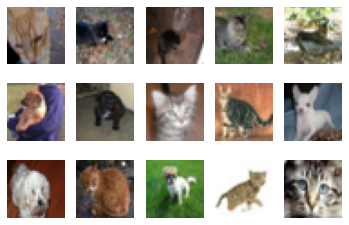

In [4]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [5]:
print(len(train_loader), len(val_loader), len(test_loader))

8000 2000 2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

The purpose of the validation dataset is to give an unbiased estimate of the skill of the final tuned model when comparing or selecting between final models.
If we judge the performance of our models using the training set, we might overlook the possibility of overfitting and the model could perform unexpectly bad in real life scenario in the future.

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [6]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [7]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [8]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [9]:
sum = 0
for param in small_net.parameters():
    print(param.shape)
    product = 1
    for i in range(len(param.shape)):
      product *= param.shape[i]
    sum += product
print("The total number of parameters in small_net is", sum)

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])
The total number of parameters in small_net is 386


In [10]:
sum = 0
for param in large_net.parameters():
    print(param.shape)
    product = 1
    for i in range(len(param.shape)):
      product *= param.shape[i]
    sum += product
print("The total number of parameters in large_net is", sum)

torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])
The total number of parameters in large_net is 9705


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [11]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

batch_size=64, learning_rate=0.01, num_epochs=30

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

The files written to disk are training errors, training losses, validation errors, and validation losses. We also got a bunch of files with naming format: model_{0}_bs{1}_lr{2}_epoch{3}. These are the training and validating data under certain hyperparameters during each epoch.

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [12]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [13]:
train_net(small_net)
train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.413, Train loss: 0.6672168202400207 |Validation err: 0.3675, Validation loss: 0.6503643784672022
Epoch 2: Train err: 0.361, Train loss: 0.6414913182258606 |Validation err: 0.3745, Validation loss: 0.65001380443573
Epoch 3: Train err: 0.348625, Train loss: 0.6299228529930114 |Validation err: 0.342, Validation loss: 0.6200827620923519
Epoch 4: Train err: 0.33375, Train loss: 0.6153617701530456 |Validation err: 0.3505, Validation loss: 0.6212818287312984
Epoch 5: Train err: 0.325, Train loss: 0.6043201537132263 |Validation err: 0.329, Validation loss: 0.6091922726482153
Epoch 6: Train err: 0.3135, Train loss: 0.5929135975837707 |Validation err: 0.324, Validation loss: 0.6116661541163921
Epoch 7: Train err: 0.312, Train loss: 0.5875719854831696 |Validation err: 0.3195, Validation loss: 0.599992735311389
Epoch 8: Train err: 0.30725, Train loss: 0.5794337742328644 |Validation err: 0.3065, Valida

Small net takes 93.59 seconds; large net takes 97.48 seconds. The large net takes longer time since it has one more Conv2d layer.

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

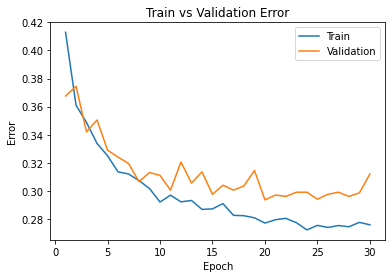

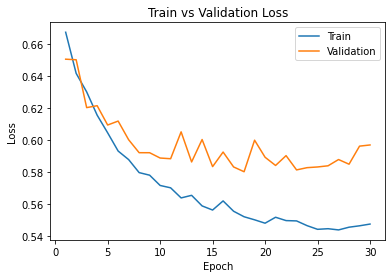

In [14]:
model_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

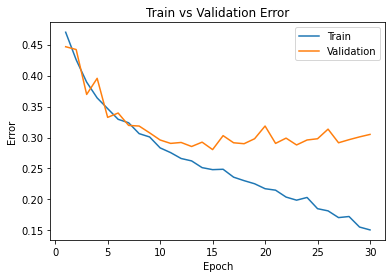

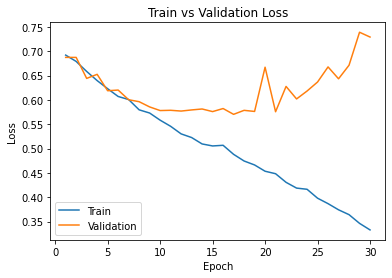

In [15]:
model_path2 = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path2)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

The training error and loss are significantly lower than validation error and loss. The small_net has their training data fluctuating and getting lower slowly throughout time; whereas large_net has faster and smoother convergence for training data to approach 0.

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

In [16]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, learning_rate=0.001)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360013961792 |Validation err: 0.467, Validation loss: 0.6924686580896378
Epoch 2: Train err: 0.448625, Train loss: 0.6922589712142945 |Validation err: 0.4305, Validation loss: 0.691649341955781
Epoch 3: Train err: 0.43575, Train loss: 0.6916067280769348 |Validation err: 0.4285, Validation loss: 0.690854424610734
Epoch 4: Train err: 0.43, Train loss: 0.690861343383789 |Validation err: 0.424, Validation loss: 0.6896595880389214
Epoch 5: Train err: 0.434125, Train loss: 0.6899195008277893 |Validation err: 0.4195, Validation loss: 0.6886935643851757
Epoch 6: Train err: 0.43575, Train loss: 0.6887411961555481 |Validation err: 0.4195, Validation loss: 0.6867824867367744
Epoch 7: Train err: 0.437125, Train loss: 0.6873774147033691 |Validation err: 0.4185, Validation loss: 0.6851982977241278
Epoch 8: Train err: 0.4375, Train loss: 0.6859278454780579 |Validation err: 0.412,

Total time elapsed is 94.35 seconds, so the model taks longer to train because of this lower learning rate. 
The training curve looks like:

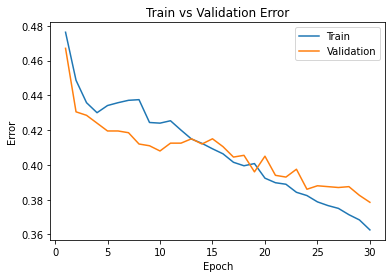

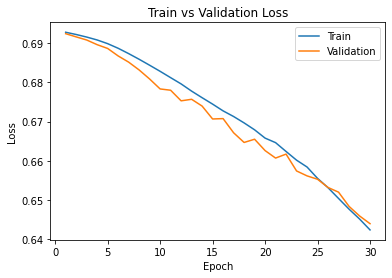

In [17]:
model_path3 = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path3)

The effect of lowering learning rate in this case actually makes the training error and loss higher than before. But it makesthe validation error and loss convergence faster and smoother.

Generally if decreasing the learning rate also increases the error and loss:
- It could be that the number of training epochs is not large enough for the smaller learning rate. This could result in the system failing to reach the optimal solution. So a small learning rate means more iterations and vice versa.

- It could also be that smaller step sizes results in the NN learning a more exact solution hence the overfitting.

In this case, since the validation error and loss are getting smaller, we rule out the possibility of overfitting, so it could be due to the first reason.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

In [18]:
large_net = LargeNet()
train_net(large_net, learning_rate=0.1)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.67437779712677 |Validation err: 0.3595, Validation loss: 0.6350857093930244
Epoch 2: Train err: 0.36075, Train loss: 0.6411805458068848 |Validation err: 0.3535, Validation loss: 0.6361209936439991
Epoch 3: Train err: 0.365125, Train loss: 0.6321813461780548 |Validation err: 0.3385, Validation loss: 0.6056603882461786
Epoch 4: Train err: 0.352625, Train loss: 0.6233456182479858 |Validation err: 0.3575, Validation loss: 0.6362800188362598
Epoch 5: Train err: 0.34075, Train loss: 0.6108013873100281 |Validation err: 0.3305, Validation loss: 0.6064918786287308
Epoch 6: Train err: 0.323375, Train loss: 0.5921835997104645 |Validation err: 0.317, Validation loss: 0.5967769594863057
Epoch 7: Train err: 0.3145, Train loss: 0.5817317583560944 |Validation err: 0.3365, Validation loss: 0.6204487886279821
Epoch 8: Train err: 0.29825, Train loss: 0.5660300073623658 |Validation err: 0.

Total time elapsed is 95.16 seconds, so the model taks less time to train because of this higher learning rate. 
The training curve looks like:

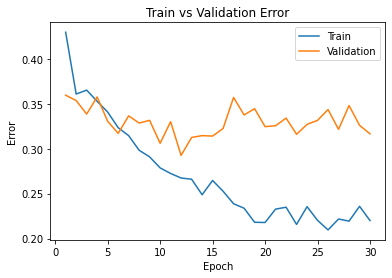

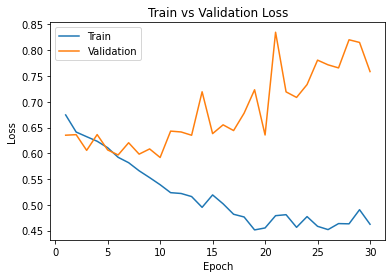

In [19]:
model_path3 = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(model_path3)

The effect of lowering learning rate in this case is that the validation data failed to converge and the training data converged while fluctuating.

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

In [20]:
large_net = LargeNet()
train_net(large_net, learning_rate=0.01, batch_size=512)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104019999504 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500590741634 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449940383434 |Validation err: 0.424, Validation loss: 0.6897870451211929
Epoch 5: Train err: 0.434, Train loss: 0.6896935552358627 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.688353206962347 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871677339077 |Validation err: 0.426, Validation loss: 0.6836968809366226
Epoch 8: Train err: 0.43525, Train loss: 0.6849770769476891 |Validation err: 0.4115, Va

$\frac{Training \ sample \ size}{batch \ size}$ = number of iterations in each epoch. Thus, larger batch size will make it iterate for less time in each epoch. Total time elapsed is 86.61 seconds, so the model taks less time to train because of this higher batch size. 
The training curve looks like:

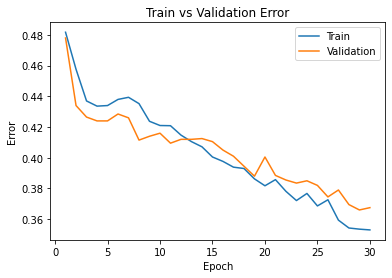

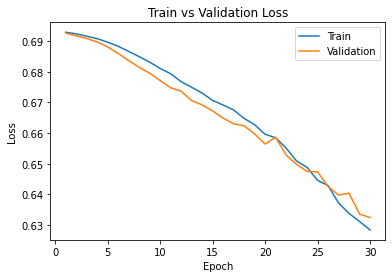

In [21]:
model_path3 = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_path3)

The effect of increasing batch size in this case makes the error and loss slightly slower to converge but still converge eventually. 

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

In [22]:
large_net = LargeNet()
train_net(large_net, batch_size=16)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774994022846222 |Validation err: 0.382, Validation loss: 0.6513170118331909
Epoch 2: Train err: 0.369, Train loss: 0.639639899969101 |Validation err: 0.3465, Validation loss: 0.6161113576889038
Epoch 3: Train err: 0.34375, Train loss: 0.6098222947120666 |Validation err: 0.3325, Validation loss: 0.6260210764408112
Epoch 4: Train err: 0.314375, Train loss: 0.5849691489338875 |Validation err: 0.34, Validation loss: 0.6044013917446136
Epoch 5: Train err: 0.301125, Train loss: 0.5689119303822517 |Validation err: 0.3125, Validation loss: 0.576918310880661
Epoch 6: Train err: 0.281, Train loss: 0.5452213581204415 |Validation err: 0.308, Validation loss: 0.5708447456359863
Epoch 7: Train err: 0.270875, Train loss: 0.5272981298565864 |Validation err: 0.307, Validation loss: 0.5854293291568756
Epoch 8: Train err: 0.259375, Train loss: 0.5070905526578426 |Validation err: 0.313, 

Total time elapsed is 134.25 seconds, so the model taks longer time to train because of this smaller batch size, because the number of iterations in each epoch increases.
The training curve looks like:

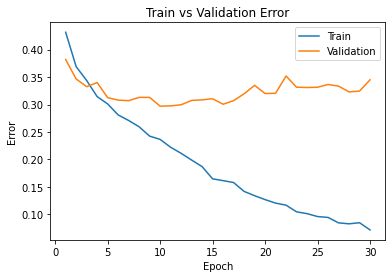

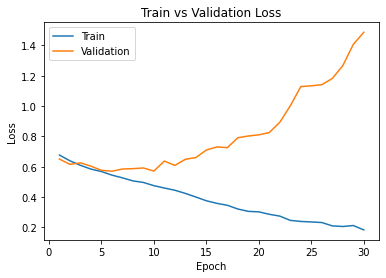

In [23]:
model_path4 = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(model_path4)

The effect of lowering batch size in this case leads to overfitting since the training data converges perfectly but the training data had to spike up due to potential overfitting.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

In [24]:
# learning rate = 0.005
# batch size = 64
# using large net
# 30 epochs

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

In [25]:
large_net = LargeNet()
train_net(large_net,learning_rate=0.005,batch_size=64, num_epochs = 30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4525, Train loss: 0.6918498063087464 |Validation err: 0.429, Validation loss: 0.6890992466360331
Epoch 2: Train err: 0.441375, Train loss: 0.6870906538963318 |Validation err: 0.4175, Validation loss: 0.6815983336418867
Epoch 3: Train err: 0.419125, Train loss: 0.68000403881073 |Validation err: 0.414, Validation loss: 0.672147274017334
Epoch 4: Train err: 0.4075, Train loss: 0.6727880077362061 |Validation err: 0.4, Validation loss: 0.665028927847743
Epoch 5: Train err: 0.393125, Train loss: 0.665095594406128 |Validation err: 0.3895, Validation loss: 0.6580633874982595
Epoch 6: Train err: 0.375625, Train loss: 0.654603937625885 |Validation err: 0.378, Validation loss: 0.6485581416636705
Epoch 7: Train err: 0.372375, Train loss: 0.6454356808662415 |Validation err: 0.3775, Validation loss: 0.6415849085897207
Epoch 8: Train err: 0.35675, Train loss: 0.6330658750534057 |Validation err: 0.3545, V

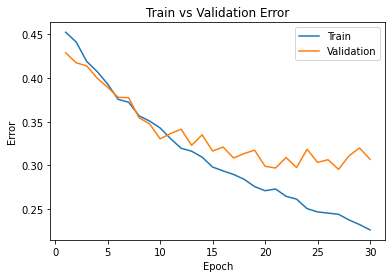

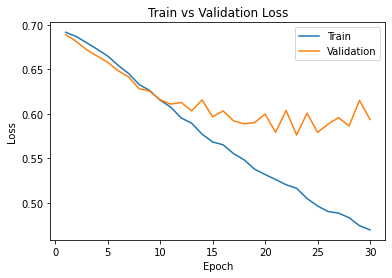

In [26]:
model_path5 = get_model_name("large", batch_size=64, learning_rate=0.005, epoch=29)
plot_training_curve(model_path5)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

- learning rate = 0.005
- batch size = 512 since it seems like the validation data is spiking up so maybe there's overfitting so larger batch size will lead to less iteration within each epoch
- using large net
- 30 epochs

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

In [27]:
large_net = LargeNet()
train_net(large_net,learning_rate=0.005,batch_size=512)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.486125, Train loss: 0.6930099949240685 |Validation err: 0.4925, Validation loss: 0.6929330974817276
Epoch 2: Train err: 0.4745, Train loss: 0.6927304826676846 |Validation err: 0.46, Validation loss: 0.6924416720867157
Epoch 3: Train err: 0.453875, Train loss: 0.6923640854656696 |Validation err: 0.439, Validation loss: 0.6920483112335205
Epoch 4: Train err: 0.447625, Train loss: 0.6920197159051895 |Validation err: 0.4325, Validation loss: 0.6916171312332153
Epoch 5: Train err: 0.43625, Train loss: 0.6915771439671516 |Validation err: 0.427, Validation loss: 0.6910792589187622
Epoch 6: Train err: 0.436, Train loss: 0.6911384649574757 |Validation err: 0.4275, Validation loss: 0.6905113160610199
Epoch 7: Train err: 0.439875, Train loss: 0.6906684786081314 |Validation err: 0.4265, Validation loss: 0.6898608803749084
Epoch 8: Train err: 0.44375, Train loss: 0.6901445500552654 |Validation err: 0.4

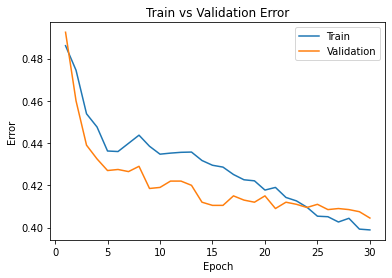

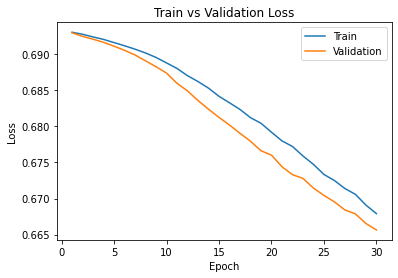

In [28]:
model_path6 = get_model_name("large", batch_size=512, learning_rate=0.005, epoch=29)
plot_training_curve(model_path6)

## Part 5. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [29]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=64, learning_rate=0.001, epoch=29)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

I choose the model from Part4 (a) since both the training and validation errors are approaching as low as 0.36 and the training and validation loss are approaching as low as 0.64.

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [30]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=64)

Files already downloaded and verified
Files already downloaded and verified


To calculate test classification error, I choose to use BCEWithLogitsLoss

> This loss combines a Sigmoid layer and the BCELoss in one single class. This version is more numerically stable than using a plain Sigmoid followed by a BCELoss as, by combining the operations into one layer, we take advantage of the log-sum-exp trick for numerical stability.

It outputs criterion.





In [31]:
criterion = nn.BCEWithLogitsLoss()
err, loss = evaluate(net, test_loader, criterion)

In [32]:
print("The test classification error is ", err)

The test classification error is  0.3695


In [33]:
print("The test classification loss is ", loss)

The test classification loss is  0.6407448202371597


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [34]:
err_val, loss_val = evaluate(net, val_loader, criterion)

In [35]:
print("The validation error is ",err_val)

The validation error is  0.3785


I would expect lower test classification error than validation error because test classification error is supposed to reveal the final performance of the model on a new group of data. However, the usage of validation data is to reveal any overfitting and adjust the weights to retrain. Thus, if the validation error is higher than test classfication error, then there is probably some degree of overfitting in the model.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

The model learns by find patterns in data that we feed into. Thus, in order to get the most accurate representation of the performance of the model, we need to feed in test dataset that the model has never seen before. The data set also needs to be small so that the model won't learning from it during the training which might lead to it trying to overfit to get a better result in the test.

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

In [72]:
class ANN_MNISTClassifier(nn.Module):
    def __init__(self):
        super(ANN_MNISTClassifier, self).__init__()
        self.name = "ann"
        self.fc1 = nn.Linear(3 * 32 * 32, 50)
        self.fc2 = nn.Linear(50, 20)
        self.fc3 = nn.Linear(20, 1)  

    def forward(self, img):
        flattened = img.view(-1, 3 * 32 * 32)
        activation1 = F.relu(self.fc1(flattened))
        activation2 = F.relu(self.fc2(activation1))
        output = self.fc3(activation2)
        output = output.squeeze(1) # Flatten to [batch_size]
        return output
    
    print('Artificial Neural Network Architecture (aka MLP) Done')

Artificial Neural Network Architecture (aka MLP) Done


In [73]:
net = ANN_MNISTClassifier()

In [74]:
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=64)

Files already downloaded and verified
Files already downloaded and verified


In [81]:
def train_ann(model, learning_rate = 0.001, num_epochs = 30, batch_size = 64):
  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

  iters, losses, train_acc, val_acc = [], [], [], []
  n = 0
  for epoch in range(num_epochs):  # loop over the dataset multiple times
    for imgs, labels in iter(train_loader):
      for i in range(len(labels)):
        actual = torch.tensor(labels[i].item()==3).reshape([1]).type(torch.FloatTensor)
        out = model(imgs[i].view(-1,3*32*32))             # forward pass
        loss = criterion(out, actual) # compute the total loss
        loss.backward()               # backward pass (compute parameter updates)
    optimizer.step()              # make the updates for each parameter
    optimizer.zero_grad()         # a clean up step for PyTorch



In [88]:
train_ann(net)
err, loss = evaluate(net, train_loader, criterion)
print("The error and loss is", err, ",", loss)

The error and loss is 0.49775 , 42.45903459167481


In [89]:
err, loss = evaluate(net, val_loader, criterion)
print("The validation error and loss is", err, ",", loss)

The validation error and loss is 0.509 , 43.275734305381775


In [84]:
err, loss = evaluate(net, test_loader, criterion)
print("The test classification error and loss is", err, ",",loss)

The test classification error and loss is 0.5 24.840056359767914


In [85]:
train_ann(net, learning_rate = 0.001, num_epochs = 30, batch_size = 128 )
err, loss = evaluate(net, train_loader, criterion)
print("The error and loss is", err, loss)

The error and loss is 0.49775 30.240426208496093


In [86]:
err, loss = evaluate(net, val_loader, criterion)
print("The validation error and loss is", err, ",", loss)

The validation error and loss is 0.509 31.08908724784851


In [87]:
err, loss = evaluate(net, test_loader, criterion)
print("The test classification error and loss is", err, ",", loss)

The test classification error and loss is 0.5 30.37712335586548


I used 30 epochs and a learning rate of 0.001 with a batch size of 64 and 128. Both models have the same training, validation, and testing errors, but the loss for a batch size of 128 for training, validation, and testing is lower than for a batch size of 64. This might be because a larger batch size has fewer iterations during each epochs which prevents overfitting.